In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
np.set_printoptions(suppress=True) # scientific notation gets annoying
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import zernike as zern
from model_kit import dust
import poppy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from datetime import datetime
date_ran = datetime.now()
dr_str = date_ran.strftime("%d/%m/%Y %H:%M:%S")
print('Last date this notebook has been ran: {0}'.format(dr_str))

Last date this notebook has been ran: 29/09/2020 11:20:01


In [3]:
# initialize the data
tot_fm = 1
tot_step=6
fits_folder = 'flat_mirrors/fixed_fits/'
raw_folder = 'flat_mirrors/2018_03_23/'

opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'diam_100CA': 12.5*u.mm,
             'surf_units': u.micron,
             'label': '0p5in',
             'ring_width': 5,
             'kmid_ll': 0.1/u.mm,
             'khigh_ll': 1/u.mm}

for fmn in range(0, tot_fm):
    fm_num = fmn+1
    print('Converting flat mirror n{0} steps'.format(fm_num))
    for ns in range(0, tot_step):
        print('Analyzing Step {0}'.format(ns))
        # call in the file
        fm_loc = raw_folder+'flat_{0}_n{1}_100percent_step{2}.datx'.format(opt_parms['label'],fm_num, ns)
        surf, mask, sp = dfx.open_datx(datx_file_loc=fm_loc, diam_ca100=opt_parms['diam_100CA'])
        wavelen = sp['value'][sp['label'].index('wavelen')] # should be same for all steps
        latres = sp['value'][sp['label'].index('latres')]

        # tighten up the matrix by removing empty rows and columns
        surf, mask = dfx.mat_tight(surf, mask)

        # apply a resize
        surf, mask = dfx.reduce_ca(data=surf, mask=mask, old_ca=100, new_ca=opt_parms['ca']) 
        # write data to a matrix
        if ns==0 and fmn==0: # initialize first time
            data_set = np.zeros((tot_fm, tot_step, mask.shape[0], mask.shape[0])) # initialize
            flat_set = np.zeros((tot_fm, tot_step, np.product(mask.shape)))
        data_set[fmn, ns, :, :] = surf.value
        flat_set[fmn, ns] = np.reshape(surf.value, np.product(mask.shape))

    print('Completed flat mirror n{0} file opening to local environment\n'.format(fm_num))
            
raw_surf = data_set * surf.unit
raw_surf_flat = flat_set * surf.unit
raw_mask = mask

Converting flat mirror n1 steps
Analyzing Step 0
Analyzing Step 1
Analyzing Step 2
Analyzing Step 3
Analyzing Step 4
Analyzing Step 5
Completed flat mirror n1 file opening to local environment



In [6]:
# create all the dust maps
# center of dust
dcen_x = ([[  61, 131, 196,   0,    0,  23],
           [   9,  78, 145,   0,    0,   0],
           [   0,   0,  39, 108,  176,   0],
           [   0,   0,   0,   0,   78, 147]])
dcen_y = [77, 109, 55, 156]
dust_radius=16 # oversize for everyone, not many pixels to lose

# build dust lists
dust_set = np.zeros_like(data_set)

# This loop masks the dust per step for all the optics
for nf in range(0, tot_fm): # choose optic
    fm_num = nf+1
    
    # build all dust mask
    all_dust = np.ones((np.shape(dcen_x)[1], mask.shape[0], mask.shape[1]))
    
    # analyzing per step
    for ns in range(0, np.shape(dcen_x)[1]):
        mask_step = np.ones_like(mask).astype(float) # initialize step mask
        
        # build each dust location at the step
        for nd in range(0, np.shape(dcen_x)[0]): 
            dmc = np.zeros_like(mask)
            if dcen_x[nd][ns] != 0: # if there is a value, then make a mask. Otherwise, skip.
                dm_coord = draw.circle(r=dcen_y[nd]-1, 
                                       c=dcen_x[nd][ns]-1,
                                       radius=dust_radius, shape=mask.shape)
                dmc[dm_coord] = True
            mask_step[dmc==True] = 0 #np.nan
        all_dust[ns] = mask_step * mask
    dust_set[nf] = all_dust
        
    print('All dust masked for fm{0}'.format(fm_num))

All dust masked for fm1


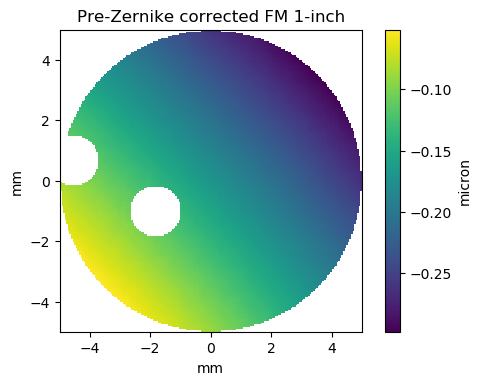

In [7]:
dfx.show_image(data=dfx.sn_map(raw_surf[0][0].value, dust_set[0][0]),
               data_unit = raw_surf.unit,
              pixscale=(latres*u.pix).to(u.mm),
              fig_title='Pre-Zernike corrected FM 1-inch')

In [8]:
# Calculate the Zernike removals
# Save the masks and surfaces to file

nt=11
n_fm = 1
zm_cor = np.zeros_like(dust_set)

for nf in range(0, tot_fm): # choose optic
    fm_num = nf+1
    
    for step in range(0, 6):
        zm = poppy.zernike.arbitrary_basis(aperture=dust_set[nf][step], nterms=nt, outside=0.0)
        zm_full = zern.gen_zernike_maps(nterms=nt, mask_full=mask)

        vec1d = np.product(dust_set[nf][step].shape)
        mask_1d_coord = np.where(np.reshape(dust_set[nf][step], (vec1d))==True)
        surfph=raw_surf[nf][step]/(wavelen.to(raw_surf.unit)/(2*np.pi*u.radian))
        active_data=np.reshape(surfph,(vec1d))[mask_1d_coord]
        zprj = np.zeros((nt))
        for j in range(0,nt):
            zactive = np.reshape(zm[j], (vec1d))[mask_1d_coord]
            dp_num=np.dot(active_data, zactive)
            dp_den=np.dot(zactive, zactive)
            zprj[j] = dp_num/dp_den

        fix_surfph = copy.copy(surfph)
        for j in range(0, nt):
            fix_surfph = fix_surfph - (zprj[j]*zm_full[j]*u.rad)
        final_surf = (fix_surfph * (wavelen.to(raw_surf.unit)/(2*np.pi*u.radian))).value

        # set up the FITS file header
        header = fits.Header()
        for n in range(0, len(sp['value'])):
            if hasattr(sp['value'][n], 'unit'):
                value = sp['value'][n].value
            else:
                value = sp['value'][n]
            header[sp['label'][n]] = (value, sp['comment'][n])
        data_diam = np.shape(mask)[0] * latres * u.pix
        ca = (data_diam/sp['value'][sp['label'].index('diam_100')].to(u.m))*100
        header['diam_ca'] = (data_diam.value, 'Data diameter at clear aperture [{0}]'.format(data_diam.unit))
        header['clear_ap'] = (ca.value, 'Clear aperture [percent]')

        surf_name = 'flat_{0}_n{1}_{2}CA_step{3}'.format(opt_parms['label'],fm_num,opt_parms['ca'],step)
        fits.writeto(fits_folder+surf_name+'_dust_mask.fits', dust_set[nf][step], header, overwrite=True)

        for zj in range(0, zprj.shape[0]):
            header['z{0}'.format(zj+1)] = (zprj[zj], 'Coeff. of Z{0} (Noll, POPPY arb. basis)'.format(zj+1))
        header['COMMENT'] = 'Surface has first {0} (Noll) Zernikes removed with dust not regarded'.format(nt)
        fits.writeto(fits_folder+surf_name+'_zern_surf.fits', final_surf, header, overwrite=True)

        zm_cor[nf][step] = final_surf
    
zm_cor = zm_cor * raw_surf.unit

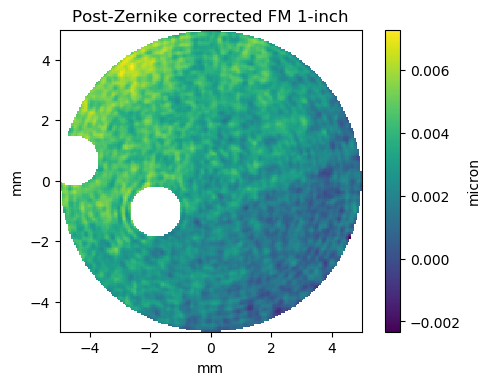

In [9]:
fmn =0
sn = 0
dfx.show_image(data=dfx.sn_map(surface=zm_cor[fmn][sn].value, mask=dust_set[fmn][sn]),
              data_unit = zm_cor.unit,
              pixscale=(latres*u.pix).to(u.mm),
              fig_title='Post-Zernike corrected FM 1-inch')

In [10]:
%%time
# do all the radial calculations
# call in the PSDs and take the radial profiles
# PSDs are calculated in separate script because it can take forever
psd_folder = 'flat_mirrors/mvls_psd/'
pos_count = 0
for nf in range(0, tot_fm): # choose optic
    fm_num = nf+1
    
    for ns in range(0, tot_step):
        mvls_name = 'lspsd_fm_{0}_n{1}_step{2}_zc.fits'.format(opt_parms['label'],fm_num,ns)
        fm_psd_fits = fits.open(psd_folder+mvls_name)[0]
        fm_psd = fm_psd_fits.data * (u.nm*u.mm)**2 # manually place in the data
        fm_dk = fm_psd_fits.header['delta_k'] / u.mm

        # build the radial frequency
        cen = int(fm_psd.shape[0]/2)
        radial_freq = np.linspace(-cen, cen-1, cen*2) * fm_dk
        radial_freq = radial_freq[cen:cen*2].value

        # calculate the radial PSD data
        k_radial, psd_radial = psd.new_psd_radial(psd_data=fm_psd, radial_freq=radial_freq)

        # initialize all the variables
        if ns==0 and nf == 0:
            fm_k_radial = np.zeros((tot_fm, tot_step, len(k_radial)))
            fm_psd_radial = np.zeros_like(fm_k_radial)
            fm_psd_total = np.zeros((tot_fm*tot_step, len(k_radial)))
        
        fm_k_radial[nf][ns] = np.asarray(k_radial)
        fm_psd_radial[nf][ns] = np.asarray(psd_radial)
        fm_psd_total[pos_count] = np.asarray(psd_radial)
        pos_count = pos_count+1

fm_k_radial = fm_k_radial * fm_dk.unit
fm_psd_radial = fm_psd_radial * fm_psd.unit
avg_psd = np.mean(fm_psd_total, axis=0) * fm_psd.unit

CPU times: user 189 ms, sys: 0 ns, total: 189 ms
Wall time: 188 ms


In [10]:
%%time
# compare with the old data
old_file = fits.open(fits_folder+'flat_1in_ca80_avg_dustmask_PSD.fits')[0]
old_data = old_file.data * (u.mm*u.nm)**2
old_dk = old_file.header['delta_k']/u.mm
old_kmin = old_file.header['k_min']/u.mm
old_k_radial, old_psd_radial = psd.do_psd_radial(ring_width=5, psd_data=old_data, dk=old_dk, kmin=old_kmin)

CPU times: user 28.7 s, sys: 9.96 s, total: 38.6 s
Wall time: 38.4 s


Text(0.5, 1.0, 'MagAO-X PSD: Flat Mirror d=0p5in with Lomb-Scargle')

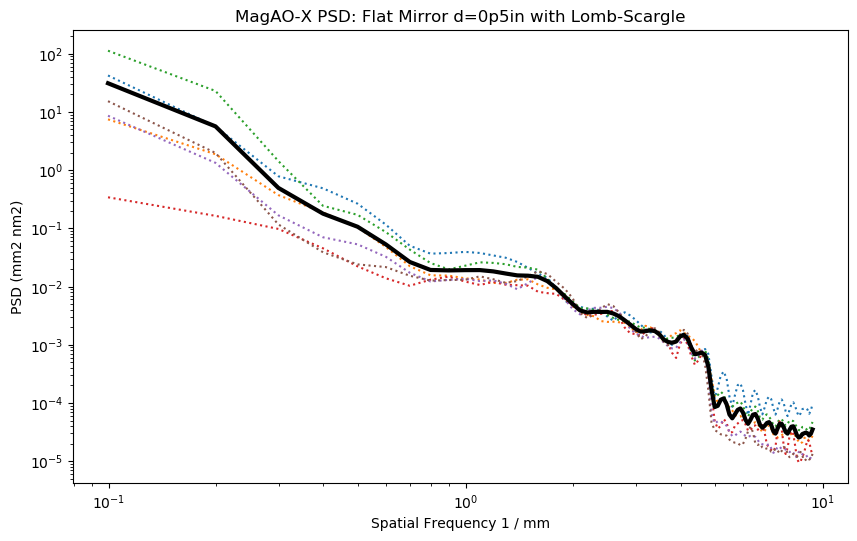

In [12]:
plt.figure(figsize=[10,6], dpi=100)
for nf in range(0, tot_fm):
    for ns in range(0, 6):
        plt.loglog(fm_k_radial[nf][ns].value, fm_psd_radial[nf][ns].value, ':', label='n{0}_s{1}'.format(nf,ns))
plt.loglog(fm_k_radial[nf][ns].value, avg_psd.value, 'k', linewidth=3, label='average')
#plt.loglog(old_k_radial.value, old_psd_radial, 'r', linewidth=3, label='old version')
plt.xlabel('Spatial Frequency {0}'.format(fm_k_radial.unit))
plt.ylabel('PSD ({0})'.format(fm_psd_radial.unit))
plt.title('MagAO-X PSD: Flat Mirror d={0} with Lomb-Scargle'.format(opt_parms['label']))
#plt.legend(prop={'size':9})

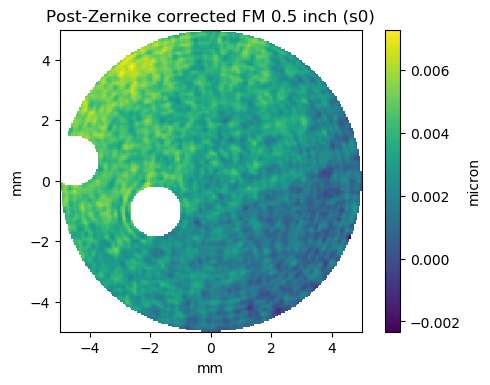

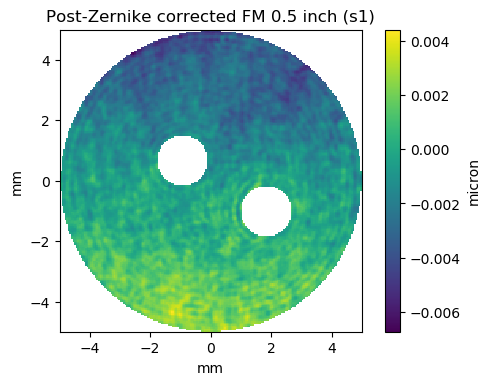

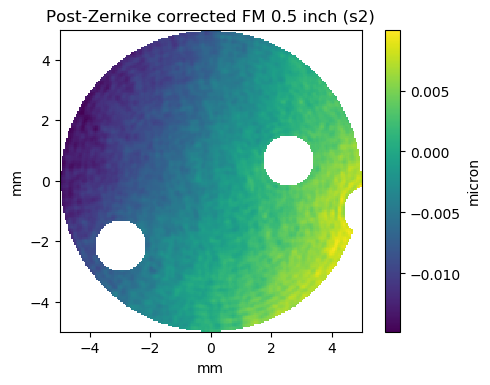

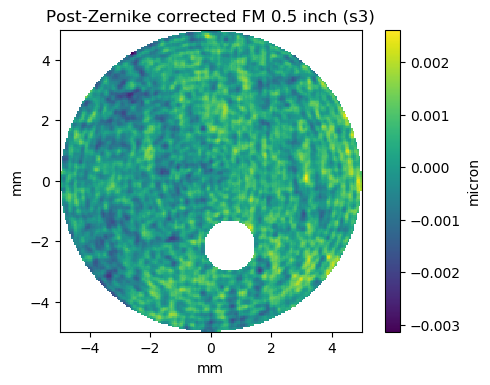

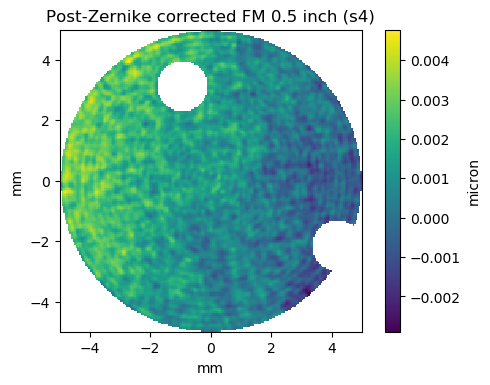

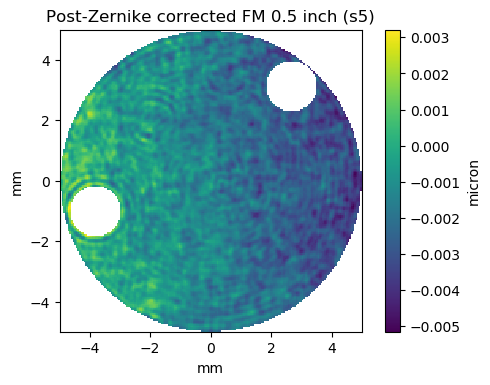

In [15]:
for ns in range(0, tot_step):
    dfx.show_image(data=dfx.sn_map(surface=zm_cor[fmn][ns].value, mask=dust_set[fmn][ns]),
                  data_unit = zm_cor.unit,
                  pixscale=(latres*u.pix).to(u.mm),
                  fig_title='Post-Zernike corrected FM 0.5 inch (s{0})'.format(ns))